# APRENDIZAJE DE CONJUNTOS Y BOSQUES ALEATORIOS

Supongamos que hacemos una pregunta compleja a miles de personas al azar y después agregamos sus respuestas. En la mayoría de los casos encontraremos que estas respuestas agregadas son mejores que la respuesta de un experto. Esto se denomina la *sabiduría de las masas*. De forma similar, si agregamos las predicciones de un grupo de predictores (tales como clasificadores o regresores), a menudo obtendremos mejores predicciones que con el mejor predictor individual. Un grupo de predictores se denomina *conjunto* (ensemble); por tanto, esta técnica es llamada *Aprendizaje de conjuntos* (ensemble learning) y un algoritmo de aprendizaje de conjunto se denomina *método de conjunto* (ensemble method).

Por ejemplo, podemos entrenar un grupo de clasificadores de árboles de decisión, cada uno en un subconjunto aleatorio diferente del conjunto de entrenamiento. Para hacer predicciones, basta con obtener las predicciones de todos los árboles individuales y luego predecir la clase que obtiene la mayoría de los votos. Tal conjunto de árboles de decisión se denomina *Bosque Aleatorio* (Random Forest) y, a pesar de su simplicidad, es uno de los algoritmos de Machine Learning más poderosos disponibles actualmente.

Además, como vimos en el capítulo 2, a menudo usaremos métodos de conjunto cerca del final del proyecto, una vez hayamos construido unos cuantos buenos predictores, para combinarlos en un predictor incluso mejor. De hecho, las soluciones ganadoras en las competiciones de Machine Learning a menudo involucran varios métodos de conjunto (el más famoso en la [competición del Premio de Netflix](http://netflixprize.com/)).

En este capítulo discutiremos los métodos de conjunto más populares, incluyendo *bagging*, *boosting*, *stacking* y algunos otros. También exploraremos los bosques aleatorios.

# Clasificadores de votación

Supongamos que hemos entrenado unos clasificadores, cada uno de ellos alcanzando una precisión del 80% aproximadamente. Podemos tener un clasificadores de Regresión Logística, un clasificador SVM, un clasificador Random Forest, un clasificador K-nearest neighbors y quizás algunos más.

![training_diverse_classifiers](images/ch07/training_diverse_classifiers.png)

Una forma muy sencilla de crear un clasificador aún mejor es agregar las predicciones de cada clasificador y predecir la clase que obtiene más votos. Este clasificador de votación-mayoritaria se denomina clasificador de *votación duro* (*hard voting*):

![hard_voting](images/ch07/hard_voting.png)

Sorprendentemente, este clasificador de votación a menudo alcanza una precisión más alta que el mejor clasificador del conjunto. De hecho, incluso si cada clasificador es un *aprendiz débil* (lo que significa que solo es un poco mejor que adivinar al azar), el conjunto aún puede ser un *aprendiz fuerte* (alcanzando alta precisión), siempre que haya un número suficiente de aprendices débiles y que sean lo suficientemente diversos.

¿Cómo es posible esto? La siguiente analogía puede ayudar a arrojar algo de luz sobre este misterio. Supongamos que tenemos una moneda ligeramente sesgada que tiene un 51% de probabilidad de caras y un 49% de probabilidad de salir cruz. Si la lanzamos 1.000 veces, generalmente obtendremos más o menos 510 cara y 490 cruz, por tanto mayoría de caras. Si hacemos los cálculos, encontraremos que la probabilidad de obtener una mayoría de caras despúes de 1.000 lanzamientos es cercana al 75%. Cuando más lancemos la moneda, mayor será la probabilidad (por ejemplo, con 10.000 lanzamientos, la probabilidad sube al 97%). Esto se debe a la *ley de los grandes números*: a medida que lanzamos la moneda, el ratio de caras se acercará cada vez más a la probabilidad de caras (51%). La siguiente figura muestra 10 series de lanzamientos de monedas sesgadas. Podemos ver que según aumenta el número de lanzamientos, el ratio de caras se acerca al 51%. Finalmente, las 10 series terminan tan cerca del 51% que están constantemente por encima del 50%.

In [4]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [14]:
heads_proba = 0.51
coin_tosses = (np.random.rand(10000, 10) < heads_proba).astype(np.int32)
cumulative_heads_ratio = np.cumsum(coin_tosses, axis=0) / np.arange(1, 10001).reshape(-1, 1)

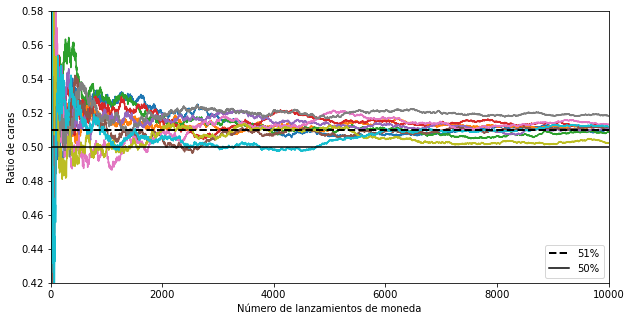

In [16]:
plt.figure(figsize=(10,5))
plt.plot(cumulative_heads_ratio)
plt.plot([0, 10000], [0.51, 0.51], "k--", linewidth=2, label="51%")
plt.plot([0, 10000], [0.5, 0.5], "k-", label="50%")
plt.xlabel("Número de lanzamientos de moneda")
plt.ylabel("Ratio de caras")
plt.legend(loc="lower right")
plt.axis([0, 10000, 0.42, 0.58]);

Del mismo modo, supongamos que contruímos un conjunto conteniendo 1.000 clasificadores que son correctos individualmente solo el 51% de las veces (apenas mejor que adivinar aleatoriamente). Si predecimos la clase votada mayoritariamente ¡podemos esperar hasta un 75% de precisión! Sin embargo, esto es cierto solo si todos los clasificadores son perfectamente independientes, haciendo errores no correlacionados, lo que claramente no es el caso, dado que están entrenados en los mismos datos. Probablemente cometerán los mismos tipos de errores, por lo que habrá mucho votos mayoritarios para la clase equivocada, reduciendo la precisión del conjunto.

---

Los métodos de conjunto trabajan mejor cuando los predictores son tan independientes entre sí como sea posible. Una forma de obtener clasificadores diversos es entrenarlos usando algoritmos muy diferentes. Esto aumenta la probabilidad de que cometan tipos de errores muy diferentes, mejorando la precisión del conjunto.

---

El siguiente código crea y entrena un clasificador de votación en Scikit-Learn, compuesto por tres clasificadores diversos (el conjunto de entrenamiento es el dataset de lunas, que vimos en el capítulo 5).

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')

In [19]:
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=42,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('rf',
                              RandomForestClassifier(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     class_weight=None,
                                               

Veamos cuál es la precisión de cada clasificador en el conjunto de prueba:

In [20]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.912


Aquí lo tenemos. El clasificador de votación supera ligeramente a todos los clasificadores individuales.

Si todos los clasificadores son capaces de estimar las probabilidades de clase (es decir, tienen un método `predic_proba()`), entonces podemos decirle a Scikit-Learn que prediga la clase con la probabilidad más alta, promediada sobre todos los clasificadores individuales. Esto se denomina *voto suave* (*soft voting*). A menudo logra un mayor rendimiento que el voto duro porque da más peso a los votos con confianza más alta. Todo lo que necesitamos es reemplazar `voting="hard"` por `voting="soft"` y asegurar que todos los clasificadores pueden estimar las probabilidades de clase. Este no es el caso por defecto de la clase `SVC`, así que necesitamos establecer su hiperparámetro `probability` a `True` (esto hará que la clase `SVC` use validación cruzada para estimar las probabilidades de clase, ralentizando el entrenamiento, y añadirá un método `predic_proba()`). Si modificamos el código precedente para usar voto suave encontraremos que el clasificador de votación alcanza una precisión del 91,2%.

In [21]:
# Soft Voting

log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", probability=True, random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=42,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('rf',
                              RandomForestClassifier(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     class_weight=None,
                                               

In [22]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.92


# Bagging y Pasting

Una forma de obtener un conjunto diverso de clasificadores es usar algoritmos de entrenamiento muy diferentes, como acabamos de ver. Otro enfoque es usar el mismo algoritmo de entrenamiento por cada predictor, pero entrenándolo en diferentes subconjuntos aleatorios del conjunto de entrenamiento. Cuando el muestreo se ejecuta *con* reemplazo, este método se denomina *bagging* (abreviatura de *bootstrap aggregating*. En estadística, el remuestreo con reemplazo se denomina *bootstrapping*). Cuando el muestreo se ejecuta *sin* reemplazo se denomina *pasting*.

En otras palabras, tanto el bagging como el pasting permiten que las instancias de entrenamiento se muestreen varias veces en múltiples predictores, pero solo el bagging permite que las instancias de entrenamiento se muestreen varias veces para el mismo predictor. Este proceso de muestreo y entrenamiento está representado en la siguiente figura:

![pasting_bagging](images/ch07/pasting_bagging.png)

Una vez que todos los predictores son entrenados, el conjunto hace una predicción para una nueva instancia agregando simplemente las predicciones de todos los predictores. Típicamente, para la clasificación la función de agregación es la *moda estadística* (es decir, la predicción más frecuente, como un clasificador de voto duro) y la *media* para la regresión. Cada predictor individual tiene un sesgo mayor que si lo entrenáramos en el conjunto de entrenamiento original, pero la agregación reduce tanto el sesgo como la varianza. Generalmente, el resultado neto es que el conjunto tiene un sesgo similar pero una menor varianza que un único predictor entrenado en el conjunto de entrenamiento original.

Como podemos ver en la figura anterior, todos los predictores se pueden entrenar en paralelo, a través de diferentes cores de CPU o incluso diferentes servidores. De forma similar, las predicciones se pueden hacer en paralelo. Esta es una de las razones de por qué el bagging y el pasting son métodos tan populares: escalan muy bien.

## Bagging y Pasting en Scikit-Learn

Scikit-Learn ofrece una API sencilla tanto para bagging como para pasting con la clase `BaggingClassifier` (o `BaggingRegressor` para la regresión). El siguiente código entrena un conjunto de 500 clasificadores de árboles de decisión (alternativamente, `max_samples` puede establecerse a un float entre 0.0 y 1.0, en cuyo caso el número máximo de instancias a muestrear es igual al tamaño del conjunto de entrenamiento por `max_samples`), cada uno entrenado en 100 instancias de entrenamiento muestreadas aleatoriamente del conjunto de entrenamiento con reemplazo (este es un ejemplo  de bagging, pero si queremos usar pasting, solo hay que establecer `bootstrap=False`). El parámetro `n_jobs` le dice a Scikit-Learn el número de cores de CPU a usar para el entrenamiento y las predicciones (`-1` le dice a Scikit-Learn que use todos los cores disponibles):

In [24]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    max_samples=100, bootstrap=True, random_state=42, n_jobs=-1)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

---

`BaggingClassifier` ejecuta automáticamente voto suave en lugar de voto duro si el clasificador base puede estimar probabilidades de clase (es decir, si tiene un método `predict_proba()`), que es el caso de los clasificadores de árboles de decisión.

---

La siguiente figura compara los límites de decisión de un único árbol de decisión con los límites de decisión de un conjunto de bagging de 500 árboles (a partir del código precedente), ambos entrenados en el dataset de lunas. Como podemos ver, las predicciones del conjunto probablemente generalizarán mejor que las predicciones del árbol de decisión en solitario: el conjunto tiene un sesgo comparable pero una menor varianza (comete aproximadamente el mismo número de errores en el conjunto de prueba, pero el límite de decisión es menos irregular).

In [25]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

0.904


In [26]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

0.856


In [27]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

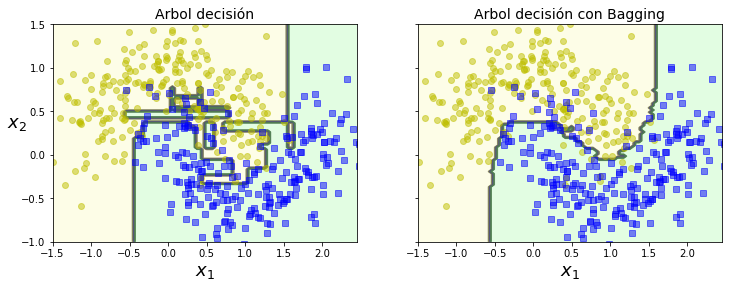

In [31]:
fix, axes = plt.subplots(ncols=2, figsize=(12,4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf, X, y)
plt.title("Arbol decisión", fontsize=14)
plt.sca(axes[1])
plot_decision_boundary(bag_clf, X, y)
plt.title("Arbol decisión con Bagging", fontsize=14)
plt.ylabel("");

Bootstrapping introduce un poco más de diversidad en los subconjuntos en los que se entrena cada predictor, por tanto, bagging termina con un sesgo ligeramente más alto que pasting, pero esto también significa que los predictores terminan estando menos correlacionados, por lo que se reduce la varianza del conjunto. En general, el bagging a menudo da como resultado mejores modelos, lo que explica por qué generalmente se prefiere. Sin embargo, si tenemos tiempo libre y potencia de CPU podemos usar validación cruzada para evaluar tanto bagging como pasting y seleccionar el que funcione mejor.

## Evaluación out-of-bag

Con bagging algunas instancias pueden ser muestreadas varias veces para cualquier predictor dado, mientras que otras puede que no sean muestreadas en absoluto. Por defecto, `BaggingClassifier` muestrea *m* instancias de entrenamiento con reemplazo (`bootstrat=True`), donde *m* es el tamaño del conjunto de entrenamiento. Esto significa que solo son muestreadas alrededor del 63% de las instancias de entrenamiento por cada predictor (si *m* crece, este ratio se aproxima a 1 - exp(-1) ≈ 63,212%). El 37% restante de las instancias de entrenamiento que no son muestreadas se denominan instancias *out-of-bag* (oob). Tengamos en cuenta que no es el mismo 37% para todos los predictores.

Dado que un predictor nunca ve las instancias oob durante el entrenamiento, puede evaluarse en esas instancias, sin necesidad de un conjunto de validación por separado. Podemos evaluar el conjunto mismo promediando las evaluaciones oob de cada predictor.

En Scikit-Learn para solicitar una evaluación oob automática después del entrenamiento podemos establecer `oob_score=True` cuando creamos un `BaggingClassifier`. El siguiente código demuestra esto. La puntuación resultante de la evaluación está disponible a través de la variable `oob_score`:

In [33]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    bootstrap=True, oob_score=True, random_state=40)

bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.9013333333333333

De acuerdo a esta evaluación oob, este `BaggingClassifier` es probable que alcance alrededor del 90,1% de precisión en el conjunto de prueba. Vamos a comprobarlo:

In [34]:
from sklearn.metrics import accuracy_score

y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.912

Obtenemos una precisión del 91,2% en el conjunto de prueba -suficientemente cerca.

# Random Patches y Random Subspaces

La clase `BaggingClassifier` también admite el muestreo de características. Esto se controla con dos hiperparámetros: `max_feautures` y `bootstrap_features`. Funcionan de la misma forma que `max_samples` y `bootstrap`, pero para muestrear características en lugar de instancias. Por lo tanto, cada predictor será entrenado en un subconjunto aleatorio de las características de entrada.

Esto es particularmente útil cuando se trata de entradas de alta dimensión (tales como imágenes). El muestreo tanto de instancias de entrenamiento como de características se denomina [método de *Random Patches*](https://homl.info/22). Mantener todas las instancias de entrenamiento (es decir, `bootstrap=False`y `max_samples=1.0`) pero muestreando las características (es decir, `bootstrap_features=True` y/o `max_features` menor que 1.0) se denomina [método de *Random Subspaces*](https://homl.info/23).

El muestreo de características da como resultado una mayor diversidad de predictores, intercambiando un poco más de sesgo por un poco menos de varianza.

# Bosques aleatorios

Como hemos discutido, un [Random Forest](https://homl.info/24) es un conjunto de árboles de decisión, generalmente entrenados a través del metodo bagging (o algunas veces pasting), típicamente con `max_samples` establecido al tamaño del conjunto de entrenamiento. En lugar de construir un `BaggingClassifier` y pasarle un `DecisionTreeClassifier`, podemos usar en su lugar la clase `RandomForestClassifier`, que es muchos más conveniente y optimizada para árboles de decisión (la clase `BaggingClassifier` será útil si queremos una "bolsa" de otras cosas que no sean árboles de decisión). De forma similar, existe una clase  `RandomForestRegressor` para tareas de regresión. El código siguiente entrena un clasificador Random Forest con 500 árboles (cada uno limitado a un máximo de 16 nodos), usando todos los cores de CPU disponibles:

In [36]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)